# Jupyter Notebook: Mapping Conditional Essentialities: A CRISPR Knockout Framework for Cancer Research

**Author(s):** 
- Anika Thatavarthy (GitHub: `AnikaTha`)
- Param Somane (GitHub: `ChestnutKurisu`)
- Andrii Dovhaniuk (GitHub: `Andreydovhaniuk`)
- Elizabeth Murphy (GitHub: `elizabethmurphy024`)

**Course:** MED 263 (Winter 2025)

---

## 0. Environment Setup

### 0.1 Clone the Repository

Run the cell below to clone your GitHub repository into the Colab environment.

In [3]:
!git clone https://github.com/ChestnutKurisu/MED263_WI25_Final_Project.git

### 0.2 Install Dependencies

This cell installs the specific packages needed by your notebook.

In [ ]:
!pip install numpy==2.1.3 pandas==2.2.3 seaborn==0.13.2 umap-learn==0.5.7 matplotlib==3.10.1 scipy==1.15.2 scikit-learn==1.6.1

---

## 1. Introduction & Background

Cancer research often leverages **CRISPR-Cas9** knockout screens to identify which genes are essential for tumor cell survival. By systematically disrupting genes, researchers can pinpoint vulnerabilities and potential therapeutic targets. However, CRISPR screens alone can be confounded by factors such as existing mutations or copy-number changes. To address this, we integrate **multi-omics** data—combining genomic and transcriptomic profiles—to better understand the context of each gene’s essentiality.

### 1.1 CRISPR-Cas9 at a Glance
- **Genome Editing**: CRISPR-Cas9 induces DNA double-strand breaks at specified genomic loci.
- **Knockout Screens**: By selectively disrupting genes across many cell lines, we can assess each gene’s impact on cell viability or proliferation.

### 1.2 Why Integrate Multi-Omics?
- **Mutation Confound**: If a tumor suppressor is already inactivated, CRISPR knockout may show little additional effect.
- **Copy-Number Confound**: High-level amplifications may appear more “essential” due to multiple CRISPR target sites.
- **Expression Confound**: A lowly expressed gene might show no effect when knocked out.  
Bringing in mutation status, copy number, and expression can reveal context-dependent (conditional) essentialities.

### 1.3 Project Aims
We aim to:
1. **Identify essential genes** across diverse cancer cell lines.
2. **Explore how mutation, copy number, and expression** influence CRISPR knockout phenotypes.
3. **Demonstrate** how integrated bioinformatics pipelines can refine gene essentiality predictions, with potential applications to precision oncology.

### 1.4 Import Libraries

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import umap.umap_ as umap
import matplotlib.pyplot as plt
from collections import Counter

from scipy.optimize import curve_fit
from scipy.stats import shapiro, levene, mannwhitneyu, ttest_ind
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score, precision_recall_fscore_support, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

----

## 2. Data Sources & Preparation

### 2.1 Data Loading & Cleaning

In [2]:
# Path to your local folder containing preprocessed DepMap CSVs
DATA_DIR = "DepMap-preprocessed"

1. **Model Metadata** (`Model.csv`)  
   - Contains **cell-line-level** descriptors (e.g., lineage, primary disease, subtype).  
   - Includes **Oncotree** annotations (e.g. `OncotreeLineage`), **CCLEName**, and other clinical/contextual fields for each model.

In [3]:
model_file = os.path.join(DATA_DIR, "Model.csv")
model_df = pd.read_csv(model_file)
model_df.head()

,ModelID,PatientID,CellLineName,StrippedCellLineName,DepmapModelType,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,OncotreeCode,PatientSubtypeFeatures,...,EngineeredModelDetails,CulturedResistanceDrug,PublicComments,CCLEName,HCMIID,ModelAvailableInDbgap,ModelSubtypeFeatures,WTSIMasterCellID,SangerModelID,COSMICID
0,ACH-000001,PT-gj46wT,NIH:OVCAR-3,NIHOVCAR3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,...,NaN,NaN,NaN,NIHOVCAR3_OVARY,NaN,Available in SRA,NaN,2201.0,SIDM00105,905933.0
1,ACH-000002,PT-5qa3uk,HL-60,HL60,AML,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia,AML,"TP53(del), CDKN2A and NRAS mutations [PubMed=2...",...,NaN,NaN,NaN,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,Available in SRA,NaN,55.0,SIDM00829,905938.0
2,ACH-000003,PT-puKIyc,CACO2,CACO2,COAD,Bowel,Colorectal Adenocarcinoma,Colon Adenocarcinoma,COAD,NaN,...,NaN,NaN,NaN,CACO2_LARGE_INTESTINE,NaN,Available in SRA,NaN,NaN,SIDM00891,NaN
3,ACH-000004,PT-q4K2cp,HEL,HEL,AML,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia,AML,"JAK2 and TP53 mutations,",...,NaN,NaN,NaN,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,Available in SRA,NaN,783.0,SIDM00594,907053.0
4,ACH-000005,PT-q4K2cp,HEL 92.1.7,HEL9217,AML,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia,AML,JAK2 and TP53 mutations,...,NaN,NaN,NaN,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,Available in SRA,NaN,NaN,SIDM00593,NaN


2. **Chronos Effect Score** (`CRISPRGeneEffect`):  
   - A negative score indicates that knocking out the gene reduces cell viability (i.e., more essential).  
   - Scores near zero or positive suggest little to no viability impact when that gene is disrupted.

In [4]:
gene_effect_file = os.path.join(DATA_DIR, "CRISPRGeneEffect.csv")
gene_effect_df = pd.read_csv(gene_effect_file)
gene_effect_df.head()

,ModelID,ALK (238),APC (324),ARID1A (8289),BRAF (673),BRCA1 (672),BRCA2 (675),CDK4 (1019),CDK6 (1021),CDKN2A (1029),...,NF2 (4771),NOTCH1 (4851),NOTCH2 (4853),NOTCH3 (4854),NOTCH4 (4855),PIK3CA (5290),PTEN (5728),RB1 (5925),SMAD4 (4089),TP53 (7157)
0,ACH-000001,-0.103312,-0.816367,-0.706872,-0.278221,-0.433829,-0.103624,-0.307988,-0.007049,0.001419,...,0.194644,-0.057918,0.049471,0.000360,-0.236105,-0.386789,0.206120,0.268744,0.046971,-0.003524
1,ACH-000004,-0.102166,-0.743033,-0.493226,0.096099,-0.309678,-0.334036,-0.714847,-0.530992,0.187944,...,0.068151,0.030226,-0.102049,-0.027544,0.027533,-0.413521,0.144275,-0.216412,-0.156126,-0.069101
2,ACH-000005,0.018104,-0.232277,-0.251699,0.141998,0.172385,-0.345666,-1.066063,-1.394510,0.047930,...,0.263568,-0.126566,-0.353719,0.049420,-0.116661,-0.469267,0.284814,0.304061,-0.175054,-0.140880
3,ACH-000007,0.010415,-0.127387,-0.519636,-0.013673,-0.648328,-0.372486,-0.699873,-1.639625,0.459440,...,0.825019,-0.136118,-0.160055,0.072980,-0.079849,-0.543013,0.982553,0.368892,-0.481521,1.386435
4,ACH-000009,-0.072744,-0.118096,0.247291,-0.020503,-0.681242,-0.313977,-0.495847,-0.173155,0.141237,...,0.822904,-0.038445,-0.090958,-0.029893,-0.073840,-0.353138,0.222170,0.195742,-0.308748,0.076981


3. **Gene Dependency** (`CRISPRGeneDependency`):  
   - Represents the probability that a cell line depends on a particular gene for survival.  
   - Typically ranges from 0 (not dependent) to 1 (highly dependent), often inferred from effect scores.

In [5]:
gene_dep_file = os.path.join(DATA_DIR, "CRISPRGeneDependency.csv")
gene_dep_df = pd.read_csv(gene_dep_file)
gene_dep_df.head()

,ModelID,ALK (238),APC (324),ARID1A (8289),BRAF (673),BRCA1 (672),BRCA2 (675),CDK4 (1019),CDK6 (1021),CDKN2A (1029),...,NF2 (4771),NOTCH1 (4851),NOTCH2 (4853),NOTCH3 (4854),NOTCH4 (4855),PIK3CA (5290),PTEN (5728),RB1 (5925),SMAD4 (4089),TP53 (7157)
0,ACH-000001,0.056537,0.893870,0.788339,0.191527,0.402028,0.056685,0.226119,0.024629,0.022809,...,3.928840e-03,0.038648,0.014677,0.023027,0.148352,0.331824,0.003544,0.002001,0.015009,0.023839
1,ACH-000004,0.056757,0.904781,0.602948,0.008394,0.271132,0.311118,0.885941,0.667848,0.003578,...,1.099418e-02,0.015962,0.056695,0.028138,0.016384,0.454986,0.005332,0.146021,0.090815,0.041859
2,ACH-000005,0.017843,0.107025,0.122120,0.007484,0.006067,0.221839,0.981517,0.998753,0.014425,...,3.126350e-03,0.050728,0.232564,0.014273,0.047233,0.417419,0.002639,0.002246,0.071764,0.056242
3,ACH-000007,0.013293,0.054030,0.610920,0.017210,0.814051,0.330852,0.868709,0.999911,0.000086,...,1.795589e-09,0.058589,0.072793,0.006740,0.034128,0.653616,0.000000,0.000296,0.538178,0.000000
4,ACH-000009,0.067575,0.101593,0.002124,0.040160,0.830001,0.358115,0.633613,0.157059,0.006484,...,1.605872e-07,0.048296,0.080025,0.044266,0.068262,0.421169,0.002719,0.003564,0.349747,0.013582


4. **Damaging Mutation** (`OmicsSomaticMutationsMatrixDamaging`):  
   - Marks likely loss-of-function or high-impact mutations.  
   - 0 = no damaging mutation
   - 1 = one or more damaging mutations with allele frequency <= 0.95
   - 2 = one or more damaging mutations with allele frequency > 0.95 (likely homozygous)

In [6]:
mut_file = os.path.join(DATA_DIR, "OmicsSomaticMutationsMatrixDamaging.csv")
mut_df = pd.read_csv(mut_file)
mut_df.head()

,ModelID,ARID1A (8289),NOTCH2 (4853),PTEN (5728),KRAS (3845),CDK4 (1019),BRCA2 (675),RB1 (5925),IDH2 (3418),CTCF (10664),...,CTNNB1 (1499),PIK3CA (5290),APC (324),NOTCH4 (4855),EGFR (1956),CDK6 (1021),MET (4233),BRAF (673),CDKN2A (1029),NOTCH1 (4851)
0,ACH-000062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ACH-001949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,ACH-000402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ACH-000693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ACH-000930,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


5. **Copy Number** (`OmicsCNGene`):  
   - Reflects relative DNA copy ratios.  
   - Amplifications (values > 1) or deletions (values < 1) can strongly modulate gene function or CRISPR outcomes.

In [7]:
cn_file = os.path.join(DATA_DIR, "OmicsCNGene.csv")
cn_df = pd.read_csv(cn_file)
cn_df.head()

,ModelID,NF2 (4771),MET (4233),BRAF (673),NOTCH3 (4854),EGFR (1956),CDK6 (1021),NF1 (4763),RB1 (5925),CTNNB1 (1499),...,ERBB2 (2064),NOTCH4 (4855),NOTCH2 (4853),ARID1A (8289),CDK4 (1019),MYC (4609),IDH1 (3417),KRAS (3845),ALK (238),BRCA1 (672)
0,ACH-000628,0.689613,0.789779,0.729782,0.964199,2.534563,0.766085,0.702596,0.698990,0.677673,...,0.698082,1.363993,0.700178,0.999906,0.717960,1.338678,1.060017,0.728302,1.043100,0.698082
1,ACH-000974,0.910934,0.950736,0.950736,1.022973,0.975396,0.950736,0.963647,1.023623,1.035990,...,0.989170,0.993625,1.021629,1.021629,1.041892,1.289464,1.022494,1.041507,1.016793,0.989170
2,ACH-003071,0.743378,1.210216,1.120761,0.764334,1.194423,1.194755,1.034125,1.074226,0.721435,...,1.083473,1.388600,1.171943,0.745936,1.120336,1.100701,1.239667,0.779162,0.699474,1.136264
3,ACH-001338,1.412051,1.611161,1.451015,0.924157,0.959519,1.501965,0.952985,0.994172,0.490650,...,1.957178,0.956183,0.894792,1.463452,0.998373,1.002211,1.042408,0.998373,0.999818,1.910216
4,ACH-001608,0.770400,1.268255,1.268255,0.803945,0.473920,1.279431,1.080812,0.712896,1.106284,...,1.088304,1.082413,1.528607,1.008400,0.790556,1.716100,1.392072,0.863143,1.104817,1.088304


6. **Expression (TPM)** (`OmicsExpressionProteinCodingGenesTPMLogp1`):  
   - Uses log2-transformed TPM (Transcripts Per Million) to measure mRNA levels.  
   - Higher values suggest greater transcription, potentially impacting CRISPR phenotypes.

In [8]:
expr_file = os.path.join(DATA_DIR, "OmicsExpressionProteinCodingGenesTPMLogp1.csv")
expr_df = pd.read_csv(expr_file)
expr_df.head()

,ModelID,BRCA1 (672),NOTCH3 (4854),CTCF (10664),CDK6 (1021),MET (4233),ARID1A (8289),PIK3CA (5290),KRAS (3845),NOTCH2 (4853),...,CDKN2A (1029),NOTCH1 (4851),BRAF (673),CTNNB1 (1499),ALK (238),PTEN (5728),IDH2 (3418),NF2 (4771),NF1 (4763),NOTCH4 (4855)
0,ACH-001113,5.427941,6.938756,5.159468,3.786596,5.125982,4.771357,5.138733,4.634012,5.102658,...,0.000000,3.008989,3.709291,7.819604,0.176323,5.198887,5.000901,3.693766,5.092546,0.807355
1,ACH-001289,3.810443,2.613532,5.182692,5.782933,1.664483,5.209453,3.184280,4.638653,7.063395,...,4.334854,1.531069,2.780310,7.425258,0.084064,5.010332,5.343763,4.048759,3.982765,0.910733
2,ACH-001339,4.497612,0.594549,4.470537,3.339137,3.687061,3.849999,3.165108,4.032101,4.674687,...,0.565597,2.469886,2.695994,7.637712,0.163499,3.046142,5.403949,4.149747,3.845992,0.807355
3,ACH-001979,2.127633,0.163499,4.677508,3.719183,1.490570,4.084915,3.273516,3.037382,4.211791,...,0.000000,2.144046,3.415488,6.656353,0.111031,5.258142,3.565597,3.431623,3.740928,0.985500
4,ACH-002438,3.890447,4.028569,4.727920,4.218006,5.709015,4.125982,3.595742,4.345538,4.221877,...,1.992768,0.704872,2.847997,7.216843,0.000000,4.885574,6.664909,4.273516,3.641546,0.432959


In [9]:
# Quick structural checks:
print("Gene Effect DF:", gene_effect_df.shape)
print("Gene Dep DF:", gene_dep_df.shape)
print("CN DF:", cn_df.shape)
print("Mutations DF:", mut_df.shape)
print("Expression DF:", expr_df.shape)
print("Model DF:", model_df.shape)

# Example column rename: For gene effect, rename "ARID1A (7157)" to "ARID1A_eff"
# We'll do this systematically:
def rename_cols_for_df(df, suffix):
    """
    For each column except 'ModelID', split on space and keep the first token (gene symbol),
    then add a suffix (e.g. '_eff', '_dep', '_CN', '_mut').
    """
    new_cols = {}
    for c in df.columns:
        if c == "ModelID":
            new_cols[c] = c
        else:
            # e.g. 'ARID1A (7157)' -> 'ARID1A'
            base_name = c.split(" ")[0]
            new_cols[c] = f"{base_name}{suffix}"
    return df.rename(columns=new_cols)

gene_effect_df = rename_cols_for_df(gene_effect_df, "_eff")
gene_dep_df    = rename_cols_for_df(gene_dep_df, "_dep")
cn_df          = rename_cols_for_df(cn_df, "_CN")
mut_df         = rename_cols_for_df(mut_df, "_mut")
expr_df        = rename_cols_for_df(expr_df, "_expr")

# Merging example: We'll demonstrate a big "merged_df" with effect, dep, CN, mut
# Merging on ModelID in a stepwise fashion
merged_df = gene_effect_df.merge(gene_dep_df, on="ModelID", how="inner")
merged_df = merged_df.merge(cn_df, on="ModelID", how="left")
merged_df = merged_df.merge(mut_df, on="ModelID", how="left")
merged_df = merged_df.merge(model_df, on="ModelID", how="left")
merged_df = merged_df.merge(expr_df, on="ModelID", how="left")

print("Final merged shape:", merged_df.shape)
merged_df.head(3)

Gene Effect DF: (1178, 30)
Gene Dep DF: (1178, 30)
CN DF: (1929, 30)
Mutations DF: (1929, 29)
Expression DF: (1673, 30)
Model DF: (2105, 47)
Final merged shape: (1178, 191)


,ModelID,ALK_eff,APC_eff,ARID1A_eff,BRAF_eff,BRCA1_eff,BRCA2_eff,CDK4_eff,CDK6_eff,CDKN2A_eff,...,CDKN2A_expr,NOTCH1_expr,BRAF_expr,CTNNB1_expr,ALK_expr,PTEN_expr,IDH2_expr,NF2_expr,NF1_expr,NOTCH4_expr
0,ACH-000001,-0.103312,-0.816367,-0.706872,-0.278221,-0.433829,-0.103624,-0.307988,-0.007049,0.001419,...,8.022978,4.130107,3.063503,7.724582,2.773996,5.381975,3.976364,6.412104,5.810186,0.389567
1,ACH-000004,-0.102166,-0.743033,-0.493226,0.096099,-0.309678,-0.334036,-0.714847,-0.530992,0.187944,...,0.124328,3.505891,3.221877,6.649328,0.000000,3.705978,7.076602,3.472488,4.016140,0.839960
2,ACH-000005,0.018104,-0.232277,-0.251699,0.141998,0.172385,-0.345666,-1.066063,-1.394510,0.047930,...,0.000000,3.542258,3.155425,7.206233,0.000000,4.011675,6.661493,3.789729,4.629357,0.641546


### 2.2 ARID1A: Biological Background

[**OMIM ARID1A entry (603024)**](https://omim.org/entry/603024)

ARID1A (*AT-RICH INTERACTION DOMAIN-CONTAINING PROTEIN 1A*) encodes a core component of the 
SWI/SNF chromatin-remodeling complex. ARID1A (also known as BAF250A) is frequently mutated 
in various cancers, particularly ovarian clear-cell carcinoma and endometrial carcinoma, 
and functions primarily as a **tumor-suppressor gene**. Germline and somatic mutations in 
ARID1A have also been associated with Coffin-Siris syndrome (MIM: 614607). 

Some notable points from [OMIM](https://omim.org/entry/603024):
- **Gene location**: 1p36.11  
- **Aliases**: BAF250A, SMARCF1  
- **Functional role**: Involved in DNA binding, chromatin remodeling, and transcriptional regulation.  
- **Clinical relevance**: Loss-of-function mutations can affect tumorigenesis (e.g., in ovarian, 
  endometrial, and other solid tumors), as well as developmental disorders.  

For a comprehensive overview of ARID1A mutations, expression patterns, and known phenotypic 
implications, please refer to the full OMIM entry linked above.

----
## 3. Exploratory Data Analysis (EDA)

Now that the data is loaded and partially merged, we can perform:
1. **Summary statistics** (mean, SD, missing values).
2. **Distributions** of CRISPR scores.
3. **Lineage-specific** boxplots (using `OncotreeLineage` in `model_df`).

We will also highlight potential pitfalls such as *copy-number effects* and how they might skew CRISPR knockout data.

### 3.1 Summary Statistics & Distributions

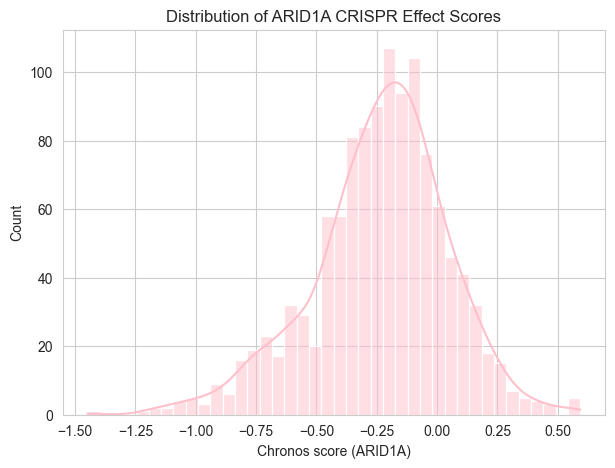

ARID1A Effect Score Summary:
 count    1178.000000
mean       -0.236170
std         0.281660
min        -1.449501
25%        -0.382751
50%        -0.210112
75%        -0.057160
max         0.593313
Name: ARID1A_eff, dtype: float64
Proportion of cell lines with ARID1A_eff < -1: 1.27%


In [10]:
# Let's pick one gene (e.g. ARID1A) and check distribution of effect scores
plt.figure(figsize=(7,5))
sns.histplot(data=merged_df, x="ARID1A_eff", bins=40, kde=True, color='pink')
plt.title("Distribution of ARID1A CRISPR Effect Scores")
plt.xlabel("Chronos score (ARID1A)")
plt.show()

# Summaries:
desc_stats = merged_df["ARID1A_eff"].describe()
print("ARID1A Effect Score Summary:\n", desc_stats)

# We can also see how many lines might be strongly essential (score < -1):
prop_ess = (merged_df["ARID1A_eff"] < -1).mean()
print(f"Proportion of cell lines with ARID1A_eff < -1: {prop_ess:.2%}")

**Interpretation**

- **Chronos scores** measure how knocking out a gene affects cell viability:  
  - **Negative scores** (below 0) imply reduced viability when the gene is knocked out (i.e., the gene is more “essential”).  
  - **Positive scores** (above 0) imply little or no reduction in viability upon knockout, and can sometimes indicate a growth advantage.  

- The **mean ARID1A score** is around **-0.236**, suggesting that in many cell lines, loss of ARID1A impairs cell growth or survival to a modest extent.
- A **small subset** of lines (about 1.27%) have **strongly negative scores (< -1)**, indicating that ARID1A knockout profoundly reduces viability—these cells are highly dependent on ARID1A.
- Another subset of lines clusters around **0 or slightly positive scores**, meaning ARID1A knockout does not meaningfully hinder—or may even promote—growth in those contexts.
- **Biologically**, ARID1A functions in chromatin remodeling and is often considered a tumor suppressor; however, its essentiality is **context-dependent**. Some cell lines require ARID1A to maintain critical regulatory functions, while others can tolerate or even benefit from its loss. This **heterogeneous distribution** illustrates how essentiality varies across different genetic or tissue backgrounds.

### 3.2 Lineage-Specific Analysis

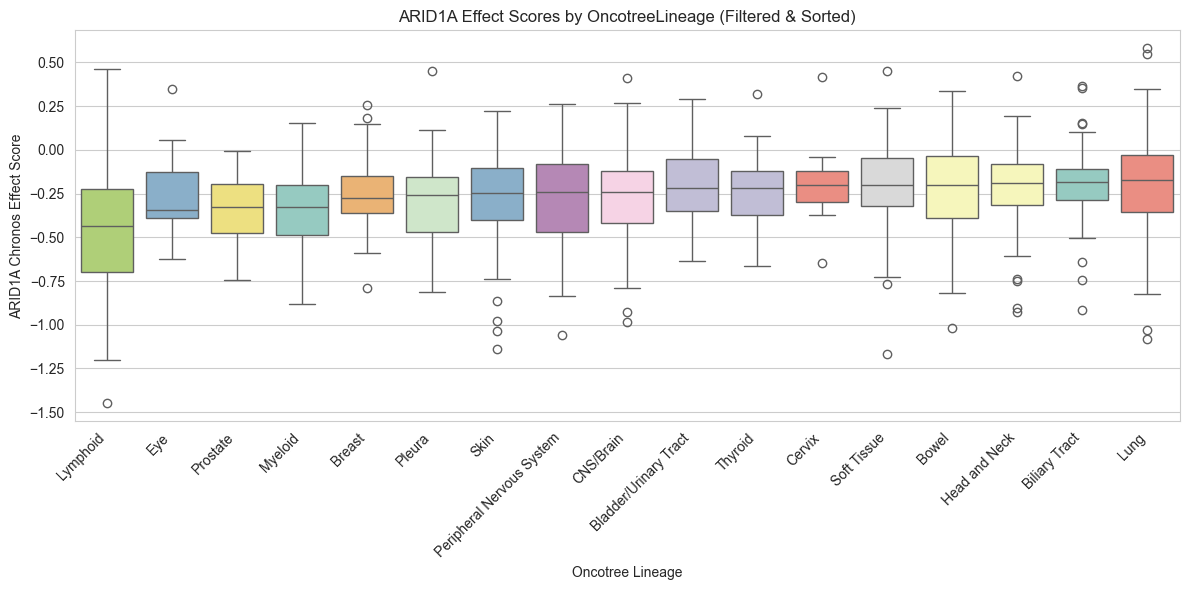

In [11]:
# 1) Filter by minimum sample size, e.g., at least 10 cell lines per lineage
min_sample_size = 10
lineage_counts = merged_df['OncotreeLineage'].value_counts()
lineages_with_enough_cells = lineage_counts[lineage_counts >= min_sample_size].index

# 2) Only keep lineages that have an "interesting" median ARID1A_eff
#    (For instance, here we require the median to be below -0.15)
lineage_median = merged_df.groupby('OncotreeLineage')['ARID1A_eff'].median()
lineages_of_interest = lineage_median[lineage_median < -0.15].index

# Combine both filters (sample size & any “interesting” criterion)
selected_lineages = lineages_with_enough_cells.intersection(lineages_of_interest)

# 3) Subset the main DataFrame to only these lineages
lineage_subset = merged_df[merged_df['OncotreeLineage'].isin(selected_lineages)].copy()

# 4) Determine a sorted order by median ARID1A_eff, so boxplots go from lowest → highest
sorted_lineages = (
    lineage_subset.groupby('OncotreeLineage')['ARID1A_eff']
    .median()
    .sort_values()
    .index
)

# 5) Plot using a palette that can handle multiple categories (e.g., "Set2", "tab20", etc.)
plt.figure(figsize=(12, 6))
sns.boxplot(data=lineage_subset, x='OncotreeLineage', y='ARID1A_eff', order=sorted_lineages, palette=sns.color_palette("Set3", n_colors=len(selected_lineages)), hue='OncotreeLineage')

plt.title("ARID1A Effect Scores by OncotreeLineage (Filtered & Sorted)")
plt.xlabel("Oncotree Lineage")
plt.ylabel("ARID1A Chronos Effect Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Interpretation**  
- Lymphoid lines display the most negative median ARID1A effect (i.e., lower scores), suggesting that ARID1A is more essential in these cells.  
- Lung lines exhibit a broad range of effect scores (and multiple outliers), indicating high heterogeneity in ARID1A dependency.  
- Overall, the variability of ARID1A effect scores across these lineages highlights tissue-specific differences in ARID1A essentiality.

---

## 4. Dimensionality Reduction & Clustering

We can attempt **PCA** or **UMAP** on either:
- **Cell lines** - Genes (to cluster cell lines by their dependency profiles).
- **Genes** - Cell lines (to cluster genes by their co-dependency patterns).

Below, we demonstrate PCA on cell lines (rows) across a subset of genes of interest.

### 4.1 PCA

PCA explained variance: PC1=7.6%, PC2=6.8%


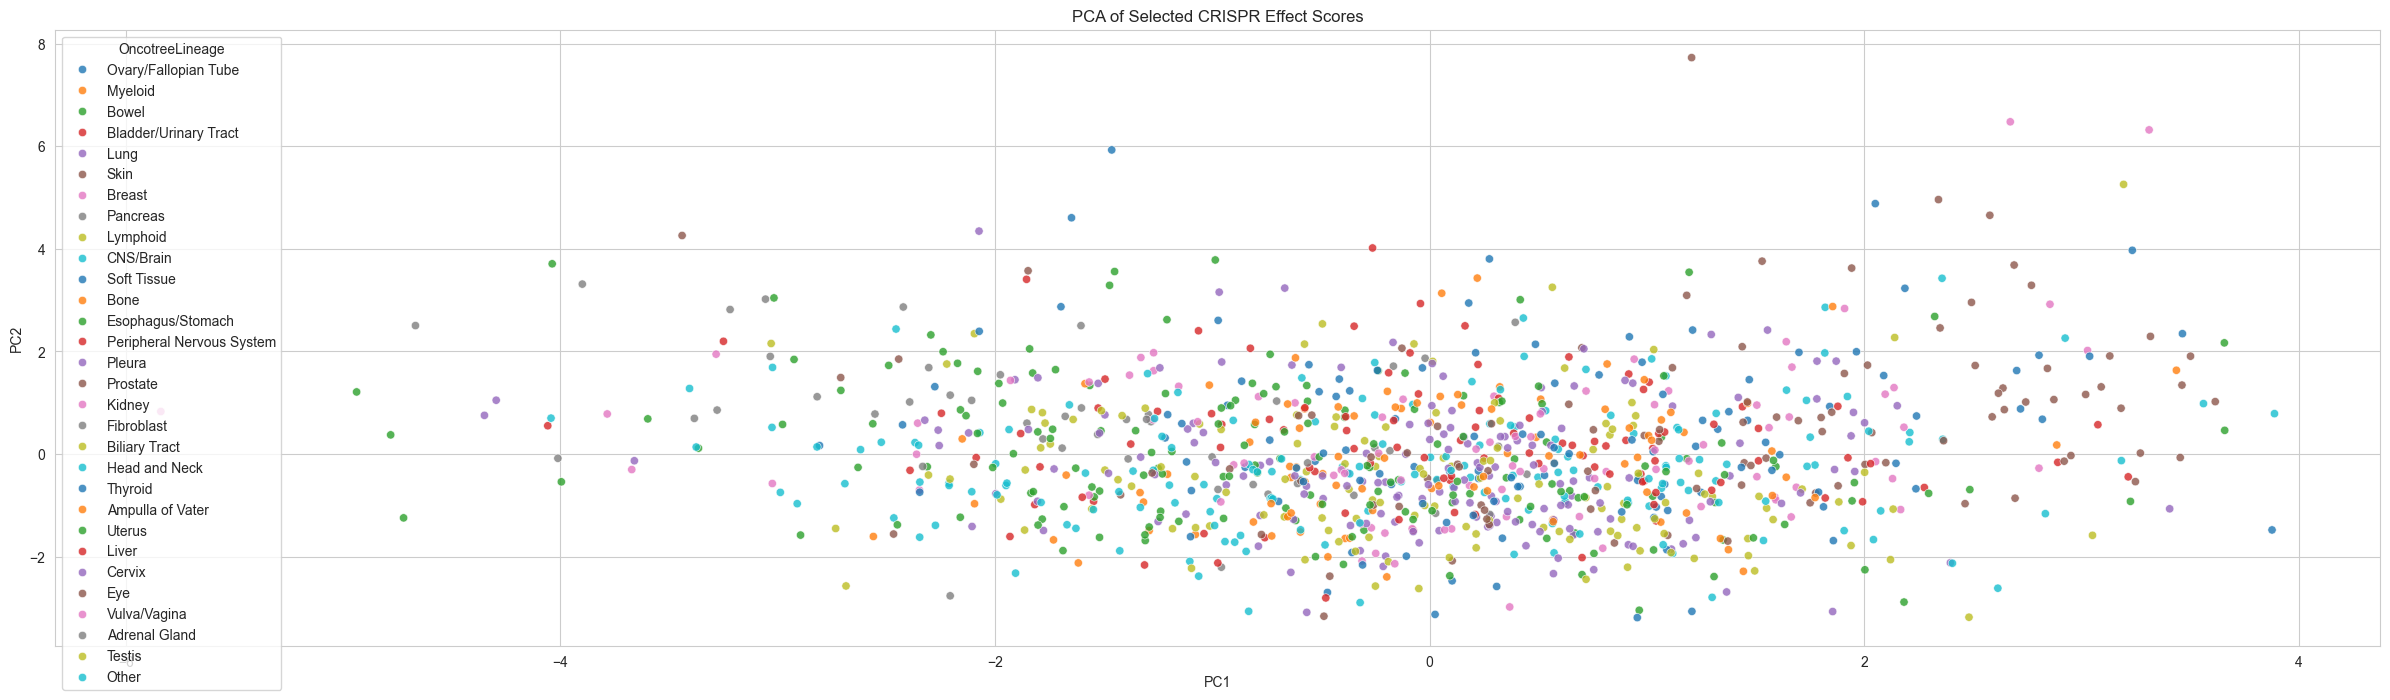

In [12]:
# Let's do a small subset of features: e.g. effect scores for 10 genes
selected_cols = [x for x in merged_df.columns if "_eff" in x]
# Keep only rows without missing for these 10 columns
df_pca = merged_df.dropna(subset=selected_cols).copy()

# Scale features
X = df_pca[selected_cols].values
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_pca["PC1"] = X_pca[:,0]
df_pca["PC2"] = X_pca[:,1]

expl_var = pca.explained_variance_ratio_ * 100
print(f"PCA explained variance: PC1={expl_var[0]:.1f}%, PC2={expl_var[1]:.1f}%")

plt.figure(figsize=(30,8))
sns.scatterplot(data=df_pca, x="PC1", y="PC2",
                hue="OncotreeLineage", alpha=0.8, palette="tab10")
plt.title("PCA of Selected CRISPR Effect Scores")
plt.show()

**Interpretation**
- PC1 (7.6%) and PC2 (6.8%) of the variance show no clear lineage-specific clustering.

### 4.2 UMAP/t-SNE

C:\Users\param\OneDrive\Documents\PyCharmProjects\UCSD-CSE\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\param\OneDrive\Documents\PyCharmProjects\UCSD-CSE\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


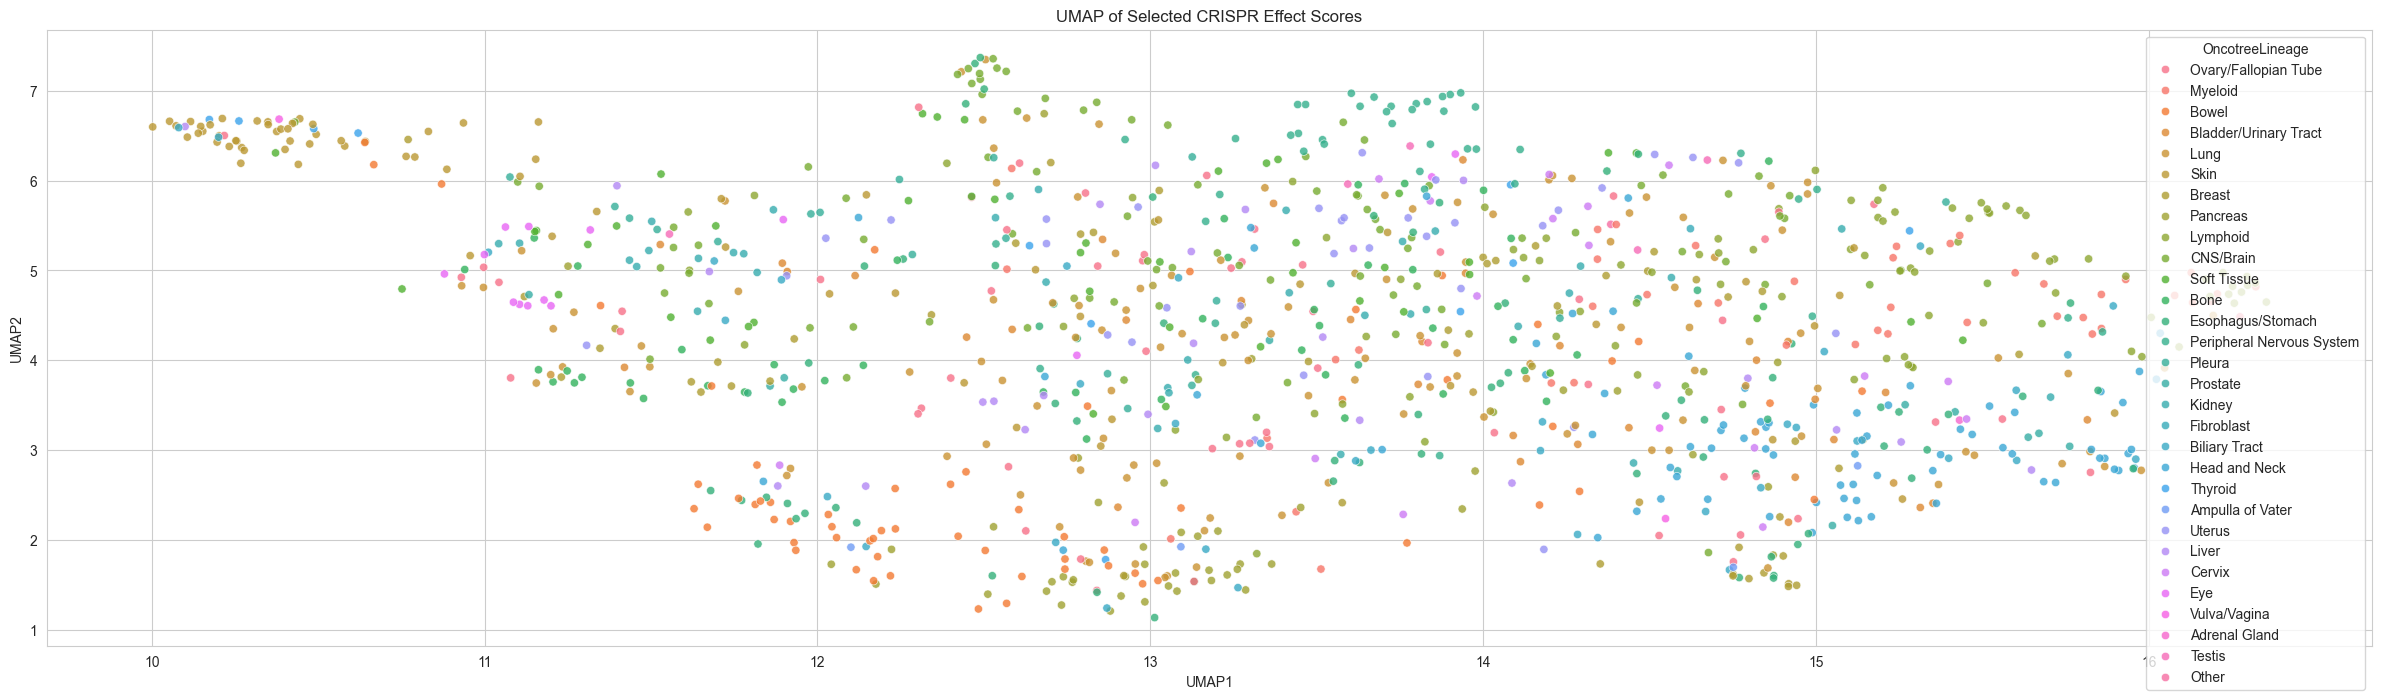

In [13]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

df_pca["UMAP1"] = X_umap[:,0]
df_pca["UMAP2"] = X_umap[:,1]

plt.figure(figsize=(30,8))
sns.scatterplot(data=df_pca, x="UMAP1", y="UMAP2", hue="OncotreeLineage", alpha=0.8)
plt.title("UMAP of Selected CRISPR Effect Scores")
plt.show()

**Interpretation**  
- The UMAP projection shows partial grouping but no distinct lineage-specific clusters.  
- This broad overlap suggests these CRISPR effect scores do not strongly separate cell lines by tissue of origin.

## 5. Statistical Tests & Multi-Omics Associations

This section outlines how we compare gene essentiality scores (e.g., ARID1A effect) across subgroups (mutant vs. wild-type (**control**), high vs. low expression) and check assumptions for parametric tests.

### 5.1 Preliminary Assumption Checks

Before applying parametric tests (e.g., t-test, ANOVA), we test:
- **Normality** using Shapiro–Wilk
- **Homogeneity of variance** using Levene’s test

If either assumption is violated, we use a nonparametric alternative (e.g., Mann–Whitney U).

In [14]:
# Create a binary column indicating whether ARID1A is mutated (>=1) or not
merged_df["ARID1A_mut_binary"] = merged_df["ARID1A_mut"].apply(lambda x: 1 if x >= 1 else 0)

# Checking ARID1A effect in mutant vs. wild-type (control) lines
mut_group = merged_df.loc[merged_df["ARID1A_mut_binary"] == 1, "ARID1A_eff"].dropna()
wt_group  = merged_df.loc[merged_df["ARID1A_mut_binary"] == 0, "ARID1A_eff"].dropna()

# Test homogeneity of variance
lev_stat, lev_p = levene(mut_group, wt_group)
print(f"Levene’s test p-value = {lev_p:.4g}")

# Test normality for each group
shap_mut_stat, shap_mut_p = shapiro(mut_group)
shap_wt_stat, shap_wt_p   = shapiro(wt_group)
print(f"Shapiro–Wilk p-value (mutant)  = {shap_mut_p:.4g}")
print(f"Shapiro–Wilk p-value (wildtype)= {shap_wt_p:.4g}")

# Decide parametric vs. nonparametric
if shap_mut_p > 0.05 and shap_wt_p > 0.05 and lev_p > 0.05:
    print("=> Use T-test")
    t_stat, t_p = ttest_ind(mut_group, wt_group, equal_var=True)
    print(f"T-test p-value = {t_p:.4g}")
else:
    print("=> Use Mann–Whitney U")
    u_stat, u_p = mannwhitneyu(mut_group, wt_group, alternative='two-sided')
    print(f"Mann–Whitney U p-value = {u_p:.4g}")

Levene’s test p-value = 0.0008734
Shapiro–Wilk p-value (mutant)  = 4.478e-07
Shapiro–Wilk p-value (wildtype)= 2.59e-08
=> Use Mann–Whitney U
Mann–Whitney U p-value = 9.167e-11


### 5.2 Mann–Whitney U (ARID1A)

The **Mann–Whitney U** (Wilcoxon rank-sum) test is a nonparametric method for **two independent groups**. 
It's useful when we suspect the data (e.g., CRISPR effect scores) may not be normally distributed.

**Question**: 
“Does the distribution of ARID1A effect scores differ between *ARID1A-mutant* lines and *wild-type* lines?”

- **Group 1**: ARID1A-mutant lines (i.e., `ARID1A_mut >= 1`)
- **Group 2**: ARID1A-wild-type lines (`ARID1A_mut == 0`)

We define a new binary column, `ARID1A_mut_binary`, where 1 = mutant (either 1 or 2) and 0 = WT.

Mann–Whitney U test for ARID1A effect (mut vs. wt):
  U-statistic = 85257.000
  p-value     = 9.1666e-11


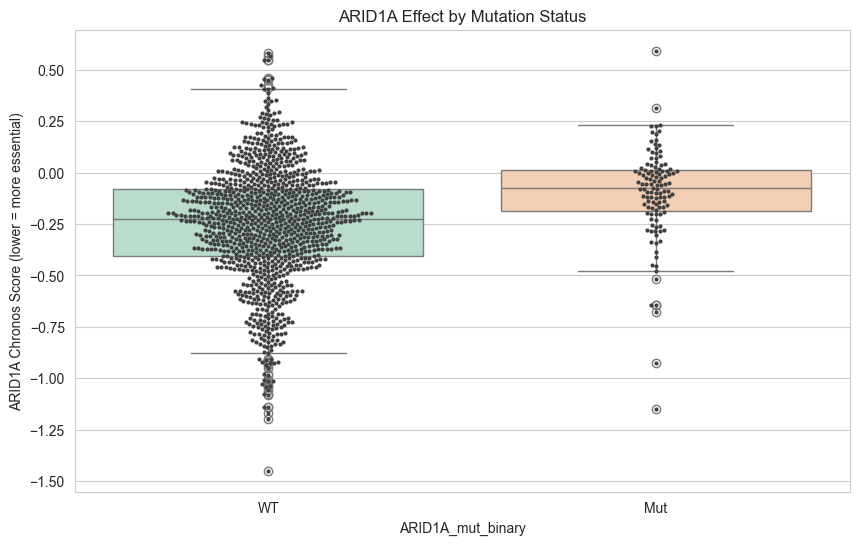

In [15]:
# Binary column: mutant vs. WT
merged_df["ARID1A_mut_binary"] = merged_df["ARID1A_mut"].apply(lambda x: 1 if x >= 1 else 0)
group_mut = merged_df.loc[merged_df["ARID1A_mut_binary"] == 1, "ARID1A_eff"].dropna()
group_wt  = merged_df.loc[merged_df["ARID1A_mut_binary"] == 0, "ARID1A_eff"].dropna()

stat, pval = mannwhitneyu(group_mut, group_wt, alternative='two-sided')
print("Mann–Whitney U test for ARID1A effect (mut vs. wt):")
print(f"  U-statistic = {stat:.3f}")
print(f"  p-value     = {pval:.5g}")

# Boxplot
temp_df = merged_df[["ARID1A_eff","ARID1A_mut_binary"]].dropna()
temp_df["ARID1A_mut_binary"] = temp_df["ARID1A_mut_binary"].map({0:"WT",1:"Mut"})

plt.figure(figsize=(10,6))
sns.boxplot(x="ARID1A_mut_binary", y="ARID1A_eff", data=temp_df, hue="ARID1A_mut_binary", palette="Pastel2", dodge=False)
sns.swarmplot(x="ARID1A_mut_binary", y="ARID1A_eff", data=temp_df, color=".25", size=3)

plt.title("ARID1A Effect by Mutation Status")
plt.ylabel("ARID1A Chronos Score (lower = more essential)")
plt.show()

**Interpretation**  
- The **Mann–Whitney U test** (p ≈ 9.17 × 10^−11) confirms a **highly significant** difference in ARID1A Chronos scores between **ARID1A-mutant** and **wild-type** cell lines.  
- **Mutant lines** display a **higher (less negative) median** ARID1A effect score, indicating that **knocking out ARID1A has a weaker impact** on viability in cells already harboring damaging ARID1A mutations. In these contexts, ARID1A’s function may be partially compromised to begin with, so further loss confers less additional effect on survival.  
- Conversely, **wild-type lines** show **more negative** ARID1A effect scores, suggesting that **ARID1A is more essential** when it remains fully functional. Knocking it out in WT cells thus causes a greater drop in viability.  
- Overall, this highlights the **context-dependent essentiality** of ARID1A: cells that have already lost part of ARID1A’s tumor-suppressive function appear less reliant on it, whereas cells with intact ARID1A experience a stronger viability defect upon its loss.

### 5.3 Correlations & Tanh Fit

#### 5.3.1 Correlation Matrix

ARID1A-related correlation matrix (Pearson):


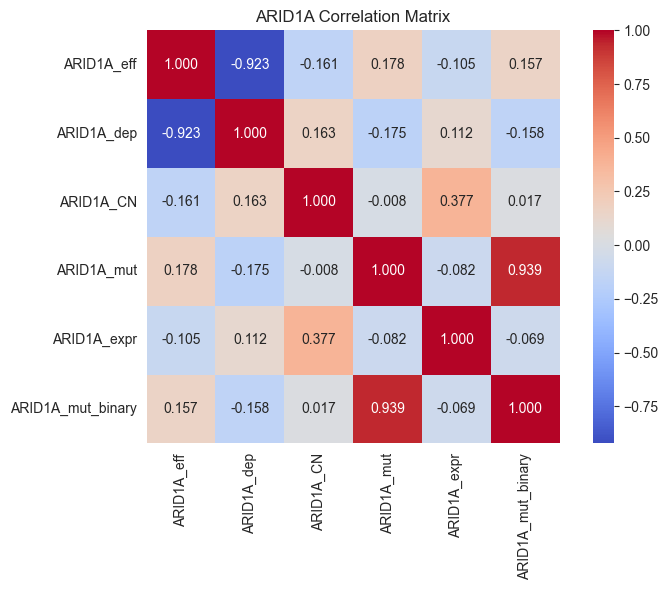

In [16]:
# Extract columns related to ARID1A
arid1a_df = merged_df[[col for col in merged_df.columns if 'ARID1A' in col]]

# Compute Pearson correlation matrix
arid1a_corr_matrix = arid1a_df.corr(method='pearson')

print("ARID1A-related correlation matrix (Pearson):")

# Plot the correlation matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(arid1a_corr_matrix, annot=True, fmt=".3f", cmap="coolwarm", square=True)
plt.title("ARID1A Correlation Matrix")
plt.tight_layout()
plt.show()

**Interpretation**  
- **ARID1A_eff vs. ARID1A_dep** has a strong negative correlation (r ~ −0.923).  
  - Interpreting Chronos effect (more negative = more essential) vs. dependency (closer to 1 = more dependent) often leads to an inverse relationship.
- **ARID1A_eff vs. ARID1A_expr** is weaker (r ~ −0.105), indicating that ARID1A expression levels do not strongly predict how essential ARID1A is in most lines. 
- **ARID1A_mut_binary** is strongly correlated with `ARID1A_mut` (r ~ 0.939), which makes sense since the binary column is derived from the mutation integer codes.

#### 5.3.2 Nonlinear Relationship (Tanh Model)

A **strong negative correlation** $(\approx −0.92)$ suggests these scores track similar biology but on different scales. To capture their *saturating* relationship, we fit a **hyperbolic tangent (tanh)** model:

$$
\text{ARID1A}_{\mathrm{dep}} \;=\; a\,\tanh\left(b\,\text{ARID1A}_{\mathrm{eff}} + c\right)\;+\;d.
$$

This accounts for how *very negative* ARID1A effect values (high essentiality) map to near-max dependency. Such nonlinear fits reflect approaches used by DepMap, where logistic/tanh transformations map CRISPR effect scores onto probabilities of dependency.<sup>[1,2]</sup>

**Interpretation**  
- Saturation at high essentiality: effect < −1 → dependency ≈ 1.  
- Inflection point marks the transition from low to high ARID1A dependency.  

<sup>**References**</sup>  
1. [Dempster, J. (2021). *Understanding the differences between CERES and Chronos DepMap data.*](https://cancerdatascience.org/blog/posts/ceres-chronos/)  
2. [DepMap Genetic Dependencies FAQ](https://forum.depmap.org/t/depmap-genetic-dependencies-faq/131)

Best-fit parameters for tanh model: [ 0.49957826 -3.6347757  -1.59957527  0.48380229]


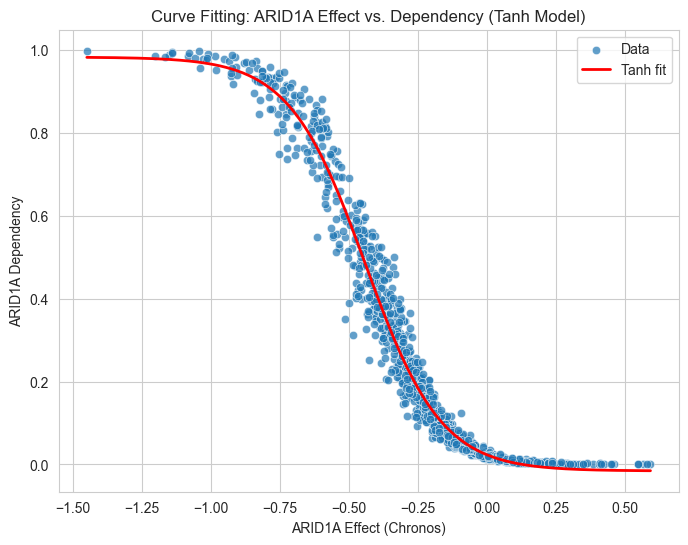

In [17]:
# Define the tanh model function
def tanh_model(x, a, b, c, d):
    """
    Model: a * tanh(b * x + c) + d
    a and d scale the output range to match dependency scores (0-1).
    b and c control the steepness and inflection point.
    """
    return a * np.tanh(b * x + c) + d

# Extract the data: x = ARID1A_eff, y = ARID1A_dep from your DataFrame 'arid1a_df'
x_data = arid1a_df["ARID1A_eff"].values
y_data = arid1a_df["ARID1A_dep"].values

# Fit the tanh model to the data
popt_tanh, pcov_tanh = curve_fit(tanh_model, x_data, y_data, maxfev=10000)
print("Best-fit parameters for tanh model:", popt_tanh)

# Generate x values for plotting the fitted curve
x_fit = np.linspace(np.min(x_data), np.max(x_data), 200)
y_fit_tanh = tanh_model(x_fit, *popt_tanh)

# Plot the data and the fitted tanh curve
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_data, y=y_data, alpha=0.7, label="Data")
plt.plot(x_fit, y_fit_tanh, color="red", lw=2, label="Tanh fit")
plt.xlabel("ARID1A Effect (Chronos)")
plt.ylabel("ARID1A Dependency")
plt.title("Curve Fitting: ARID1A Effect vs. Dependency (Tanh Model)")
plt.legend()
plt.show()

The relationship appears to be modeled well by the formula below:
$$
ARID1A_{\mathrm{dep}} \approx 0.4996\tanh(-3.6348\,ARID1A_{\mathrm{eff}} - 1.5996) + 0.4838.
$$

---

## 6. Predictive Modeling & Fairness Interventions

In the previous sections, we explored how **CRISPR effect** and **dependency** data—combined with **multi-omics** features such as mutation status, copy number (CN), and expression levels—can reveal gene essentiality patterns in cancer cell lines. Thus far, our analyses focused on exploratory data analysis (EDA), statistical comparisons (e.g., Mann–Whitney U), and correlational insights (e.g., CRISPR effect vs. gene dependency).

However, **predictive modeling** provides a more direct framework to address the following core question:

> **Which genes are essential or conditionally essential across different cancer cell lines, and how do multi-omics features shape these dependencies?**

To tackle this, we present a workflow to (i) **classify** whether a gene is “essential” given certain multi-omics features and (ii) explore **fairness interventions** to manage class imbalances and subgroup disparities. Specifically, we highlight ARID1A (or any other gene of interest, e.g. BRCA2) as a case study for how mutation status might affect essentiality predictions—and how group imbalances (mutant vs. wild-type) can confound naive models.

### 6.1 Overview & Motivation

Recall from the earlier EDA:
- **`ARID1A_mut_binary`** distribution: ~10–12% of cell lines are ARID1A-mutant (1) vs. ~88–90% wild-type (0).
- **`ARID1A_eff`** (CRISPR effect score): A more negative score indicates higher essentiality.
- **`ARID1A_essential`**: We often binarize essentiality with a threshold, e.g. `ARID1A_eff < -0.5` → 1 (essential), else 0 (non-essential).

This setup results in two main imbalances:
1. **Mutation Imbalance**: far fewer mutant lines than wild-type lines (class imbalance in the *input* feature “mutation”).
2. **Essentiality Imbalance**: far fewer cell lines are strongly dependent on ARID1A (especially if we pick a stringent threshold for essentiality).

Models trained without explicitly addressing these imbalances may trivially predict only one class (e.g., “wild-type” or “non-essential”). In such scenarios, accuracy might be high, but **recall** for the minority class becomes negligible—hindering biologically meaningful insights.

### 6.2 Logistic Regression for Gene Essentiality

Below, we illustrate a **Logistic Regression** model to classify whether ARID1A is “essential” (`ARID1A_eff < -0.5`) based on two key features:

1. **ARID1A expression** (`ARID1A_expr`)
2. **ARID1A mutation** (binarized as `ARID1A_mut_binary`)

This is a simplified example; we could add more omics features (e.g., copy number, other relevant gene features) for improved accuracy.

**Why -0.5?**  
- In DepMap’s “Genetic Dependencies FAQ,” a Chronos or CERES score of **less than -0.5** 
indicates that knocking out the gene tends to cause a **significant** depletion in most cell lines 
(i.e., the gene is “essential” in that context). Scores **less than -1** often imply a **strong** depletion.  
- See [DepMap Genetic Dependencies FAQ](https://forum.depmap.org/t/depmap-genetic-dependencies-faq/131) for more details.

Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       234
           1       0.00      0.00      0.00        42

    accuracy                           0.85       276
   macro avg       0.42      0.50      0.46       276
weighted avg       0.72      0.85      0.78       276

Confusion Matrix:
 [[234   0]
 [ 42   0]]

=== Logistic Regression Results for ARID1A Essentiality ===
Intercept: -2.8615
Coefficients [ARID1A_expr, ARID1A_mut_binary]: [ 0.25644522 -0.78814449]
Accuracy: 0.8478

Labeled Confusion Matrix:
                           Predicted Non-Essential (0)  Predicted Essential (1)
Actual Non-Essential (0)                          234                        0
Actual Essential (1)                               42                        0


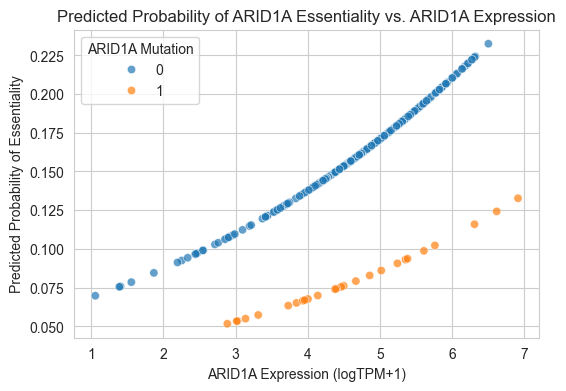

In [18]:
# Define threshold for "essential" label
ESSENTIAL_THRESHOLD = -0.5

required_cols = ["ModelID", "ARID1A_eff", "ARID1A_expr", "ARID1A_mut"]

df_clf = merged_df.dropna(subset=required_cols).copy()
df_clf["ARID1A_mut_binary"] = df_clf["ARID1A_mut"].apply(lambda x: 1 if x >= 1 else 0)
df_clf["ARID1A_essential"] = (df_clf["ARID1A_eff"] < ESSENTIAL_THRESHOLD).astype(int)

# Feature selection and train/test split ---
X = df_clf[["ARID1A_expr", "ARID1A_mut_binary"]]
y = df_clf["ARID1A_essential"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Train logistic regression model ---
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)

# Predictions and basic evaluation ---
y_pred = logreg.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Detailed results (intercept, coefficients, labeled CM) ---
intercept = logreg.intercept_[0]
coefs = logreg.coef_[0]
print("\n=== Logistic Regression Results for ARID1A Essentiality ===")
print(f"Intercept: {intercept:.4f}")
print(f"Coefficients [ARID1A_expr, ARID1A_mut_binary]: {coefs}")
print(f"Accuracy: {acc:.4f}")

cm_labeled = pd.DataFrame(
    cm,
    index=["Actual Non-Essential (0)", "Actual Essential (1)"],
    columns=["Predicted Non-Essential (0)", "Predicted Essential (1)"]
)
print("\nLabeled Confusion Matrix:\n", cm_labeled)

# Probability-based visualization ---
test_probs = logreg.predict_proba(X_test)[:, 1]
df_clf_test = df_clf.loc[X_test.index].copy()
df_clf_test["Prob_Essential"] = test_probs

plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=df_clf_test,
    x="ARID1A_expr",
    y="Prob_Essential",
    hue="ARID1A_mut_binary",
    alpha=0.7
)
plt.title("Predicted Probability of ARID1A Essentiality vs. ARID1A Expression")
plt.xlabel("ARID1A Expression (logTPM+1)")
plt.ylabel("Predicted Probability of Essentiality")
plt.legend(title="ARID1A Mutation")
plt.show()

In [19]:
df_clf["ARID1A_mut_binary"].value_counts()

ARID1A_mut_binary
0    988
1    115
Name: count, dtype: int64

**Interpretation**
- **Accuracy alone** can be misleading in imbalanced settings; check **precision**, **recall**, and **F1** for the minority class (“essential”).
- Often, the default `predict` threshold of 0.5 yields zero predictions for the minority class if the model probabilities remain below 0.5.
- We might confirm that the minority (“essential”) label is underrepresented (e.g., < 10% of lines).

### 6.3 Addressing Class Imbalance

In many CRISPR essentiality analyses, a small fraction of cell lines are strongly dependent on a given gene—leading to *class imbalance* in the target variable. Additionally, some subgroups (e.g., mutant lines) have smaller sample sizes, compounding the imbalance challenge.

#### 6.3.1 Class-Weight Adjustment

One straightforward strategy is to specify `class_weight="balanced"` in **Logistic Regression** (or similar classifiers). This reweights the loss function so that minority-class errors become more penalized.

In [20]:
logreg_bal = LogisticRegression(solver='lbfgs', class_weight='balanced')
logreg_bal.fit(X_train, y_train)

y_pred_bal = logreg_bal.predict(X_test)

acc_bal = accuracy_score(y_test, y_pred_bal)
print(f"Balanced-Weight Accuracy = {acc_bal:.3f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_bal, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))

Balanced-Weight Accuracy = 0.507
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.46      0.61       234
           1       0.20      0.76      0.32        42

    accuracy                           0.51       276
   macro avg       0.56      0.61      0.47       276
weighted avg       0.81      0.51      0.57       276

Confusion Matrix:
 [[108 126]
 [ 10  32]]


> **Note**: While `class_weight="balanced"` often improves minority-class recall, it can degrade overall accuracy or majority-class metrics. Always review the **precision–recall tradeoff** to ensure the model meets your scientific objectives.

#### 6.3.2 Oversampling & Undersampling

Alternatively, we can **oversample** minority examples or **undersample** majority examples to balance the training set. Oversampling or undersampling can make the model more sensitive to the minority class. However, **replicating the same minority data points** can risk overfitting. Advanced methods like **SMOTE** (Synthetic Minority Over-sampling Technique) generate synthetic examples to mitigate this risk.

### 6.4 Additional Logistic Examples & Feature-Wide Scans

We now extend the logistic-regression approach (previously demonstrated for ARID1A alone) to **all** genes that have a corresponding `_dep` (dependency) column in our merged dataset. For each gene:

1. We define a binary outcome: `is_essential = 1` if `gene_dep >= 0.5`.
2. We use `[gene_expr, gene_CN, mut_binary]` as predictors.
3. We skip any gene with insufficient samples or incomplete data.
4. Finally, we evaluate Accuracy and TPR (recall) for both essential (1) and non-essential (0) classes, and record how many mutants vs. wild-type lines there are. This helps us spot class imbalances.

This feature-wide scan reveals which genes are most (or least) predictable from these combined omics features.

In [21]:
results_list = []

# Identify all "gene_dep" columns in merged_df
dep_cols = [c for c in merged_df.columns if c.endswith("_dep")]

for dep_col in dep_cols:
    gene_name = dep_col.replace("_dep", "")
    expr_col = f"{gene_name}_expr"
    cn_col   = f"{gene_name}_CN"
    mut_col  = f"{gene_name}_mut"

    required = [dep_col, expr_col, cn_col, mut_col]
    if not all(r in merged_df.columns for r in required):
        continue
    
    sub_cols = ["ModelID"] + required
    df_sub = merged_df.dropna(subset=sub_cols).copy()
    
    # Skip if too few total samples
    if df_sub.shape[0] < 20:
        continue
    
    # Binarize essential
    df_sub["is_essential"] = (df_sub[dep_col] >= 0.5).astype(int)
    
    # Binarize mutation
    df_sub["mut_binary"] = df_sub[mut_col].apply(lambda x: 1 if x >= 1 else 0)
    
    X = df_sub[[expr_col, cn_col, "mut_binary"]]
    y = df_sub["is_essential"]
    
    # Skip if only one class overall
    y_counts = Counter(y)
    if len(y_counts) < 2 or min(y_counts.values()) < 2:
        continue
    
    # Train/test split (stratified if enough data)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Fit logistic regression
    clf = LogisticRegression(C=1, random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict & evaluate
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    # TPR (recall) for each class
    tpr_0 = recall_score(y_test, y_pred, pos_label=0, zero_division=0)
    tpr_1 = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    
    # Distribution of mutant vs. WT
    n_mutants = df_sub["mut_binary"].sum()
    n_wt = df_sub.shape[0] - n_mutants
    
    results_list.append({
        "Gene": gene_name,
        "N_Samples": df_sub.shape[0],
        "Num_Mutants": n_mutants,
        "Num_WT": n_wt,
        "Accuracy": acc,
        "TPR_0": tpr_0,
        "TPR_1": tpr_1
    })

results_df = pd.DataFrame(results_list).sort_values(by="Accuracy", ascending=False)
results_df.reset_index(drop=True, inplace=True)

results_df

,Gene,N_Samples,Num_Mutants,Num_WT,Accuracy,TPR_0,TPR_1
0,RB1,1103,67,1036,1.000000,1.000000,0.000000
1,ALK,1103,7,1096,0.995475,0.995455,1.000000
2,CTCF,1103,29,1074,0.995475,0.000000,1.000000
3,NOTCH1,1103,36,1067,0.995475,1.000000,0.000000
4,IDH1,1103,5,1098,0.995475,1.000000,0.000000
5,TP53,1103,699,404,0.995475,1.000000,0.000000
6,NOTCH2,1103,17,1086,0.990950,1.000000,0.000000
7,PTEN,1103,113,990,0.990950,1.000000,0.000000
8,NF1,1103,64,1039,0.986425,1.000000,0.000000
9,NF2,1103,30,1073,0.977376,1.000000,0.000000


**Interpretation**

The table above shows, for each gene:
- **Accuracy** in classifying “essential vs. non-essential.”
- **TPR_0**: recall for non-essential lines.
- **TPR_1**: recall for essential lines.
- **Num_Mutants** vs. **Num_WT**: distribution of mutated vs. wild-type lines (which can skew results if extremely imbalanced).

In some cases, you might see high accuracy but TPR_1 = 0 (the model never calls a line “essential”). Class imbalance is a recurring theme, as we discussed. Meanwhile, certain genes might be quite predictable from their expression, copy number, and mutation data (Accuracy near 1.0 for both classes). This approach helps you quickly screen which genes are best captured by a simple logistic model.

### 6.5 Fairness Interventions

Although “fairness” is typically discussed in social contexts, the **concept of group fairness** can be extended here. Suppose we treat *mutation status* (e.g., ARID1A-mutant vs. wild-type) as a “group” and want to ensure that predictions do not systematically disadvantage one group. For instance, if our classifier underpredicts essentiality in mutant lines, we might systematically lose critical targets specifically for the mutant subgroup.

#### 6.5.1 Massaging & Reweighting

Two commonly discussed techniques in fairness literature are:

1. **Massaging**:  
   - Based on a “ranker” that orders how borderline each instance is w.r.t. the positive class (essential).  
   - We flip labels for the most “deserving” negatives in the minority group and the least “deserving” positives in the majority group—up to a small number `M` needed to correct group disparities.

2. **Reweighting**:  
   - Compute per-group and per-class weights so that each subgroup’s presence is “normalized” in the training distribution.  
   - Classic formula used in *Feldman et al. (2015)* or related fairness papers: $W(z, c) = \frac{\text{group\_counts}[z] \times \text{class\_counts}[c]}{\text{total\_count} \times \text{joint\_counts}[z][c]}$.

#### 6.5.2 Group-Specific Thresholds

Even after training a model, we can apply **post-processing** to reduce disparity between groups (e.g., mutant vs. wild-type). If the model’s *probabilities* systematically differ between groups, we can choose **lower thresholds** for the group predicted to have fewer positives.

For example, set:
- `threshold_mutant = 0.3`
- `threshold_wt = 0.5`

so that the mutant group is more likely to be labeled “essential.” This can help ensure that we do not *underestimate* essentiality for smaller or more biologically complex subpopulations.

> **Caution**: This approach can raise interpretability concerns, as different cutoffs for different subgroups might be perceived as “preferential” or might not reflect true biology. However, if you have a strong prior or domain knowledge that one subgroup’s data systematically shifts the predicted probabilities, a group-specific threshold can be a pragmatic solution.

## 7. Conclusions & Next Steps

We have performed a pipeline integrating **CRISPR effect/dependency** data, **mutation**, **copy-number**, and **expression** data, plus optional external references. This reveals key insights into which genes are essential, and in which contexts.

### 7.1 Biological Validation
- The final step in any in silico CRISPR screen is experimental validation. If a gene emerges as conditionally essential (say, only in PTEN-mutant lines), test that gene knockout in isogenic cell lines with and without PTEN mutation.
- Alternatively, use base editors to mutate specific hotspots to confirm the essential region of a gene's coding sequence.

### 7.2 Common Pitfalls & How to Avoid Them
1. **Addressing Copy-Number Artifacts**: CRISPR screens can artificially identify high-copy genes as "essential" due to multiple cut sites. DepMap’s Chronos algorithm corrects for these biases ([Meyers et al., Nature Genetics 2017](https://doi.org/10.1038/ng.3984)). We therefore use Chronos-corrected scores (CRISPRGeneEffect.csv) to limit CN confounds. If you have raw log-fold changes, consider implementing CERES or Chronos yourself or removing genes with extreme amplifications from your analysis.
2. **Batch Effects**: DepMap screens over multiple years; unify or correct if necessary.
3. **Data Mismatch**: Genes named differently (e.g., `ARID1A` vs. `ARID1A (7157)`). Consistent gene naming is crucial.
4. **Small Sample Size for Rare Cancers**: Subtype-specific essentialities may be underpowered.
5. **Class Imbalance**: Certain genes are essential in only a minority of cell lines, or certain subtypes (e.g., mutant vs. wild-type) have vastly different sample sizes. This can cause models to ignore the minority class. Consider techniques like **class weighting**, **oversampling**, or **group-specific thresholds** to improve recall of rare but important subgroups.

### 7.3 References

1. **DepMap Data Portal**: [https://depmap.org/portal/](https://depmap.org/portal/)  
2. **CERES**:  
   Meyers RM *et al.* (2017). *Computational correction of copy number effect improves specificity of CRISPR–Cas9 essentiality screens in cancer cells.*  
   *Nat Genet* 49, 1779–1784. [DOI:10.1038/ng.3984](https://doi.org/10.1038/ng.3984)  
3. **Chronos**:  
   Dempster JM *et al.* (2021). *Chronos: a cell population dynamics model of CRISPR experiments that improves inference of gene fitness effects.*  
   *Genome Biol* 22, 343. [DOI:10.1186/s13059-021-02540-7](https://doi.org/10.1186/s13059-021-02540-7)  
4. **BioGRID ORCS**: [https://orcs.thebiogrid.org/](https://orcs.thebiogrid.org/)  
5. **Base Editor Screens**:  
   Gaudelli NM *et al.* (2017). *Programmable base editing of A•T to G•C in genomic DNA without DNA cleavage.*  
   *Nature* 551, 464–471. [DOI:10.1038/nature24644](https://doi.org/10.1038/nature24644)  
6. Additional references in the text above.

**Thank you for following along with this multi-omics CRISPR integration tutorial!**